In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from pandas_profiling import ProfileReport

In [2]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self;
    def transform(self, X):
        return X[self.attribute_names].values

In [3]:
class MyLabelEncoder(LabelEncoder):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(MyLabelEncoder, self).fit(X)
    def transform(self, X, y=None):
        return super(MyLabelEncoder, self).transform(X)
    def fit_transform(self, X, y=None):
        tmp = super(MyLabelEncoder, self).fit(X).transform(X)
        return tmp.reshape(len(tmp), 1)

# Importing and loading files

Let us import and load our datasets.

In [4]:
statcast_df = pd.read_csv('data/2019-statcast.csv')
batters_df = pd.read_csv('data/batter-names.csv')

# Exploratory Data Analysis

Here are the available columns for the `statcast_df` dataset. Their meaning is described on the [Statcast documentation](https://baseballsavant.mlb.com/csv-docs).

In [5]:
statcast_df.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'zone', 'des', 'game_type', 'stand', 'p_throws',
       'home_team', 'away_team', 'type', 'balls', 'strikes', 'game_year',
       'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'vx0', 'vy0',
       'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc',
       'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate',
       'release_extension', 'game_pk', 'pitcher.1', 'release_pos_y',
       'launch_speed_angle', 'at_bat_number', 'pitch_number', 'pitch_name',
       'home_score', 'away_score', 'bat_score', 'fld_score', 'post_away_score',
       'post_home_score', 'post_bat_score', 'post_fld_score',
       'if_fielding_alignment', 'of_fielding_alignment', 'spin_axis',
       'delta_home_win_exp', 'delta_run_exp'],
      dty

Here, instead, are the first entries of the `batters_df` dataset.

In [6]:
batters_df.head()

,key_mlbam,batter_name
0,547989,"abreu, josé"
1,660670,"acuna, ronald"
2,542436,"adames, cristhian"
3,642715,"adames, willy"
4,613534,"adams, austin"


I have chosen the `description` column as my target column. It's a **categoric feature** with 13 unique categories.

In [7]:
statcast_df.description.unique()

array(['swinging_strike', 'foul', 'ball', 'called_strike',
       'hit_into_play', 'swinging_strike_blocked', 'blocked_ball',
       'hit_by_pitch', 'foul_bunt', 'foul_tip', 'missed_bunt', 'pitchout',
       'bunt_foul_tip'], dtype=object)

We make a selection out of the features and narrow them down to the following: `['inning', 'inning_topbot', 'outs_when_up', 'balls', 'strikes', 'stand', 'p_throws', 'effective_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'sz_top', 'sz_bot']`.

In [8]:
statcast_df = statcast_df[['inning', 'inning_topbot', 'outs_when_up', 'balls', 'strikes', 'stand', 
 'p_throws', 'effective_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 
 'pfx_z', 'plate_x', 'plate_z', 'sz_top', 'sz_bot', 'description']]

Our `statcast_df` dataset now looks like this.

In [9]:
statcast_df.head()

,inning,inning_topbot,outs_when_up,balls,strikes,stand,p_throws,effective_speed,release_spin_rate,spin_axis,pfx_x,pfx_z,plate_x,plate_z,sz_top,sz_bot,description
0,9,Bot,2,3,2,L,R,87.8,2461.0,175.0,0.02,0.21,0.88,1.03,3.35,1.40,swinging_strike
1,9,Bot,2,3,2,L,R,94.4,2572.0,201.0,-0.57,1.52,-0.47,1.92,3.35,1.56,foul
2,9,Bot,2,2,2,L,R,95.3,2637.0,205.0,-0.66,1.40,1.68,1.35,3.53,1.63,ball
3,9,Bot,2,2,1,L,R,94.9,2598.0,208.0,-0.81,1.50,0.75,2.05,3.35,1.56,foul
4,9,Bot,2,1,1,L,R,87.0,2598.0,186.0,-0.05,0.47,1.27,2.17,3.59,1.63,ball


Now I define numerical and categorical variables for simplicity's sake.

In [10]:
numerical = ['inning', 'outs_when_up', 'balls', 'strikes', 'effective_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'sz_top', 'sz_bot']
categorical = ['inning_topbot']

## EDA - Pandas Profiling

Let us take a peek at basic features of the dataset: histograms, missing values, correlations (just as a first check for multicollinearity, making deductions now would be wrong!).

In [11]:
profile = ProfileReport(statcast_df, title="Pandas Profiling Report")

In [12]:
#profile.to_notebook_iframe()

We see that some data is missing: in particular `sz_bot`, `sz_top`, `plate_z`, `plate_x`, `pfx_z`, `pfx_x`, `spin_axis` have all exactly 7332 missing entries. `release_spin_rate` has 20084 missing entries (2.7% of the entire dataset) and `effective_speed` has 4889 missing entries.

From the **missing values heatmap** we can see that the first group of features with missing entries totally correlate each other. This might suggest the fact that the absence of these features is due to a lack of measurement tools in those events, or the absence of necessity or the impossibility to record these measurements due to the nature of the recorded event.

Either way, I am not a *connoisseur* of baseball technicalities 🙃 so I will simply delete those rows. I could come up with ways to imput the data, but I would have to know the meaning of zero, NaN or infinite values in those variables. I know this is rough, but it is surely better than having to deal with NaNs.

In [13]:
statcast_df = statcast_df.dropna()

## EDA - Visualization

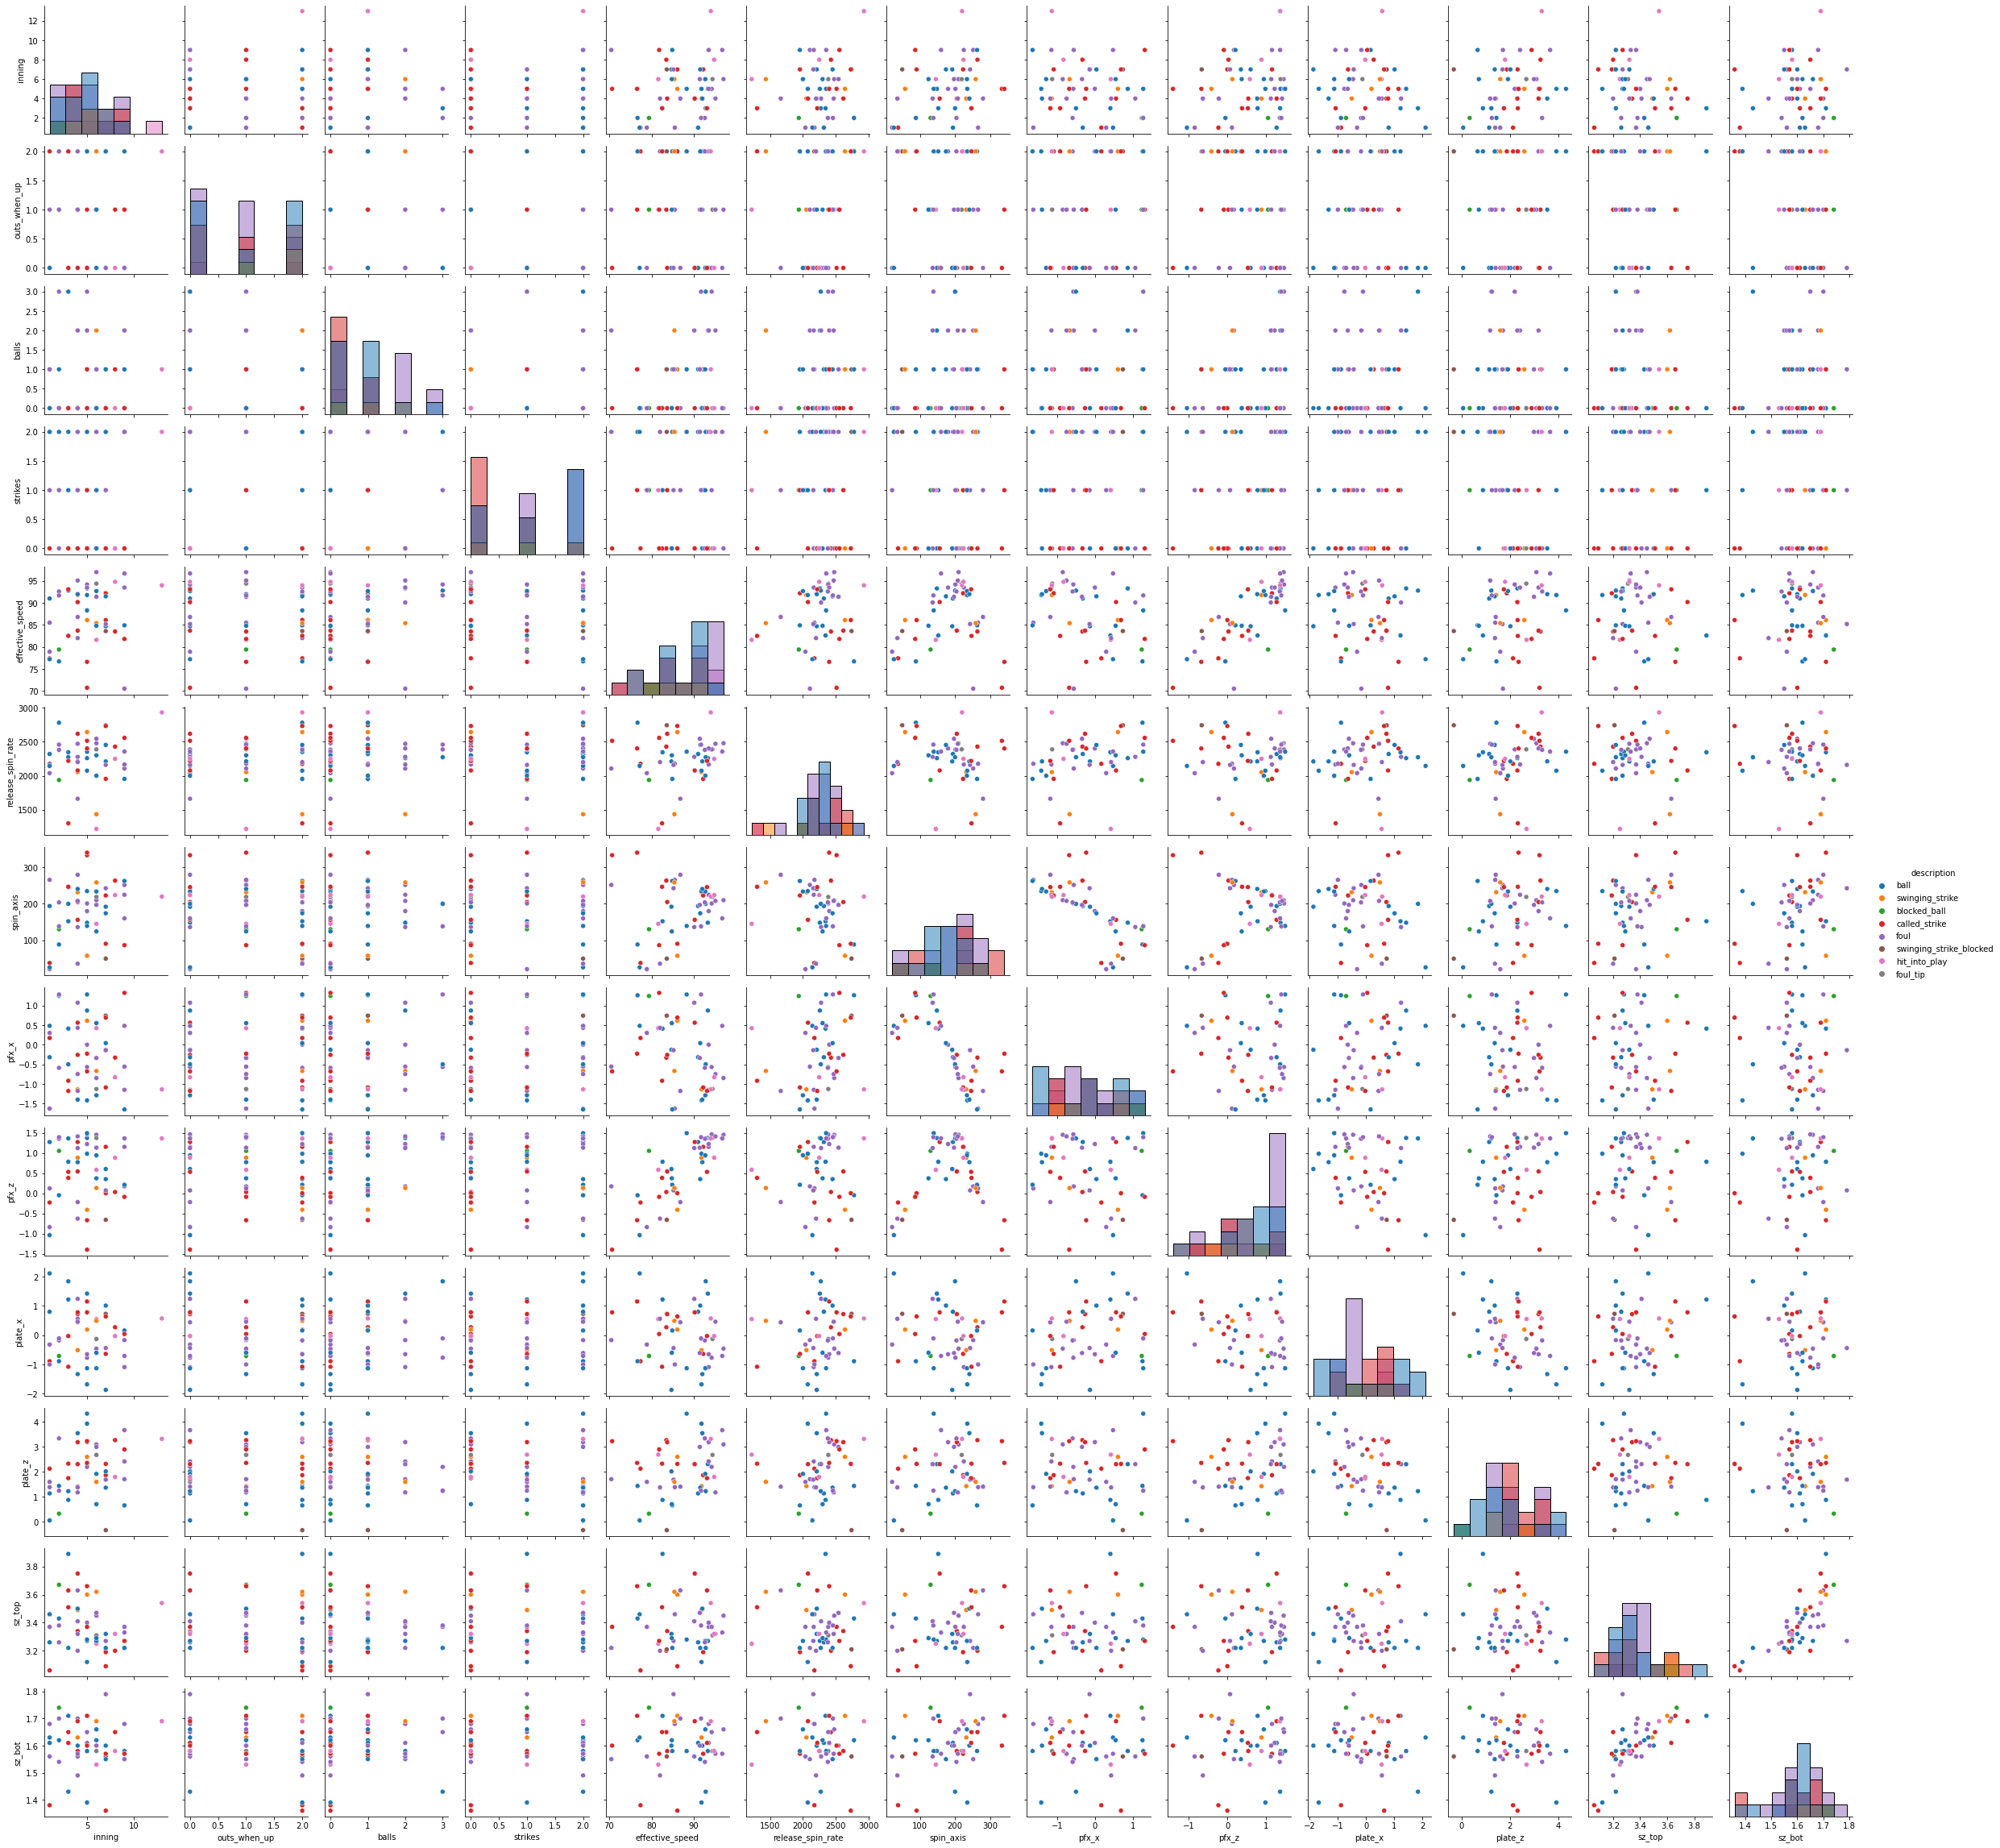

In [14]:
g = sns.PairGrid(statcast_df.sample(n=50), hue='description')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

# Splitting Training set and Test set

Let's do important tasks right away: let us split *training* and *test* sets. It is crucial to do this as soon as possible as to avoid overfitting on testing data. We can subsequently divide the original training set in further two sets (the *training* and *validation* sets) in order to compare the performance of different algorithms over our dataset.

In [15]:
X = statcast_df.iloc[:, :-1]
y = statcast_df.iloc[:, -1]

In [16]:
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X, y, test_size=0.3, shuffle=True)

# Preprocessing data

## Encoding categorical features

We will now prepare data for the first stages of the analysis. We would firstly like to **correctly encode categorical features with numerical values**, and we will use the `LabelEncoder` provided by `sklearn`. In this case we will have to do this with features `stand`, `p_throws` and `description`.

## Scaling

We will then **standardize** or **normalize** numerical features for the analysis to behave in a correct manner, [depending on the sparsity of the data](http://www.faqs.org/faqs/ai-faq/neural-nets/part2/section-16.html). We **do not have** strange outliers in most of the numerical columns, so we can safely standardize them.

In [17]:
le = LabelEncoder()

In [18]:
num_pipeline = Pipeline([
    ('selector', DataFrameSelector(numerical)),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(categorical)),
    ('label_encoder', MyLabelEncoder()),
])

full_pipeline = FeatureUnion(transformer_list = [
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [20]:
X_train_pre

,inning,inning_topbot,outs_when_up,balls,strikes,stand,p_throws,effective_speed,release_spin_rate,spin_axis,pfx_x,pfx_z,plate_x,plate_z,sz_top,sz_bot
494911,4,Bot,2,1,0,R,L,83.7,2285.0,142.0,1.11,1.40,-0.04,1.80,3.72,1.75
434208,6,Top,2,0,0,L,R,97.7,2378.0,202.0,-0.63,1.55,-0.73,2.92,3.15,1.57
246858,1,Top,0,0,0,R,R,92.9,2213.0,197.0,-0.49,1.63,-0.55,3.70,3.35,1.68
258460,4,Bot,1,0,1,R,R,90.9,2439.0,206.0,-0.60,1.22,0.45,2.79,3.12,1.49
327405,7,Bot,2,1,1,R,R,88.4,2173.0,264.0,-1.77,0.17,-1.09,1.71,3.41,1.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334610,6,Bot,2,0,1,R,L,94.3,2236.0,174.0,0.16,1.47,0.17,1.68,3.36,1.65
527896,9,Bot,0,3,2,L,R,96.8,2229.0,190.0,-0.18,1.00,0.10,1.45,3.25,1.59
429423,9,Top,0,0,1,L,R,82.6,1199.0,264.0,-0.82,0.08,-0.79,1.23,3.63,1.70
516214,4,Bot,2,0,2,R,R,79.5,2923.0,64.0,1.33,-0.66,1.15,1.14,3.07,1.42


In [21]:
X_train = full_pipeline.fit_transform(X_train_pre)
le.fit(y_train_pre)
y_train = le.transform(y_train_pre)

/usr/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


# Models

## Importing models

We will import models from `sklearn` for **multiclass classification** (one target feature with multiple cardinality). In this analysis we will make a comparison between the following inherently multiclass models:

- Decision Tree Classifier
- Extremely Randomized Tree Classifier
- k-Nearest Neighbor
- Random Forest Classifier

and the following one-versus-the-rest models:

- Support Vector Classifier
- Logistic Regression
- Perceptron

In [24]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.multiclass import OneVsRestClassifier

In [25]:
dtc = DecisionTreeClassifier()
etc = ExtraTreeClassifier()
knc = KNeighborsClassifier()
rfc = RandomForestClassifier()
svc = OneVsRestClassifier(LinearSVC())
logistic = OneVsRestClassifier(LogisticRegression())
percep = OneVsRestClassifier(Perceptron())

In [26]:
def cross_validate(model, features, target):
    scores = cross_val_score(model, features, target, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean(), rmse_scores.std()

models = [dtc, etc, knc, rfc, svc, logistic, percep]

In [27]:
training_rmse = []
for model in models:
    mean, std = cross_validate(model, X_train, y_train)
    training_rmse.append([mean, std])
training_rmse = np.array(training_rmse)

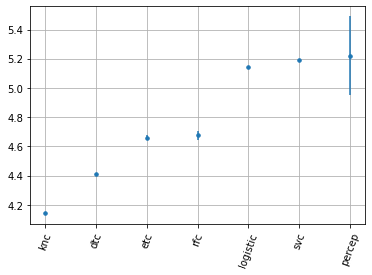

,model,error,errorstd
0,knc,4.142819,0.006030
1,dtc,4.410065,0.005327
2,etc,4.660169,0.017105
3,rfc,4.676255,0.029782
4,logistic,5.143457,0.001318
5,svc,5.189452,0.002533
6,percep,5.221691,0.268360


In [31]:
rmse_models = pd.DataFrame({'model': ['dtc', 'etc', 'knc', 'rfc', 'svc', 'logistic', 'percep'], 'error': training_rmse[:, 0],'errorstd': training_rmse[:, 1]})
#rmse_models['error'] = rmse_models.error.apply(lambda x: int(round(x)))
rmse_models = rmse_models.sort_values('error').reset_index(drop=True)
fig1, ax1 = plt.subplots()
ax1.grid()
ax1.errorbar(rmse_models['model'], rmse_models['error'], yerr=rmse_models['errorstd'], marker='.', ms=7, fmt=' ')
plt.xticks(rotation=70)
plt.show()

display(rmse_models)